# Repositorios codigos metodologia amenaza #2

En este notebook se encuentran los codigo especificos para el analisis de la precipitacion a nivel de antioquia a detalle proporcionado por la entidad SIATA, a si mismo se hacen los joins para obtener las bases de datos y poder usar power BI para amenaza, susceptibilidad y acumulado mensual de precipitacion.

# Conversion NC a RASTER

In [ ]:
import os
import rasterio
from rasterio import shutil as rio_shutil

# Ruta de la carpeta base original
input_base = r"D:\2025-1\ANALISIS_DATOS\Proyecto\2024"
# Ruta de la carpeta base de salida
output_base = r"D:\2025-1\ANALISIS_DATOS\Proyecto\2024_procesado"

# Recorremos todos los meses
for mes in sorted(os.listdir(input_base)):
    mes_path = os.path.join(input_base, mes, "Acumulados_1")
    
    if not os.path.isdir(mes_path):
        continue  # Saltar si no existe la carpeta esperada
    
    # Ruta de salida equivalente
    out_mes_path = os.path.join(output_base, mes, "Acumulados_1")
    os.makedirs(out_mes_path, exist_ok=True)
    
    # Recorremos todos los .nc del mes
    for file in os.listdir(mes_path):
        if file.lower().endswith(".nc"):
            nc_path = os.path.join(mes_path, file)
            
            # Definir nombre de salida cambiando extensión a .tif
            tif_name = os.path.splitext(file)[0] + ".tif"
            tif_path = os.path.join(out_mes_path, tif_name)
            
            try:
                # Abrimos el netCDF
                with rasterio.open(nc_path) as src:
                    # Verificamos que tenga una banda
                    if src.count > 0:
                        profile = src.profile
                        profile.update(driver="GTiff")
                        
                        with rasterio.open(tif_path, "w", **profile) as dst:
                            for i in range(1, src.count + 1):
                                dst.write(src.read(i), i)
                
                print(f"✅ Convertido: {nc_path} → {tif_path}")
            
            except Exception as e:
                print(f"❌ Error con {nc_path}: {e}")

# Join Espacial de precipitacion a los movimientos

In [ ]:
import geopandas as gpd
import rasterio
import numpy as np
import os
from datetime import datetime
import pandas as pd
from rasterio.transform import rowcol
import warnings

# Suprimir advertencias
warnings.filterwarnings('ignore')

def extraer_valores_por_coordenadas(raster_path, x_centro, y_centro, buffer_grados):
    """
    Extrae valores del raster usando coordenadas directamente, sin mask.
    """
    try:
        with rasterio.open(raster_path) as src:
            # Leer todos los datos del raster
            data = src.read(1)
            transform = src.transform
            
            # Calcular límites del buffer
            x_min = x_centro - buffer_grados
            x_max = x_centro + buffer_grados
            y_min = y_centro - buffer_grados
            y_max = y_centro + buffer_grados
            
            # Convertir coordenadas geográficas a índices de píxeles
            try:
                row_min, col_min = rowcol(transform, x_min, y_max)  # esquina superior izquierda
                row_max, col_max = rowcol(transform, x_max, y_min)  # esquina inferior derecha
                
                # Asegurar que los índices estén dentro del raster
                row_min = max(0, min(row_min, data.shape[0] - 1))
                row_max = max(0, min(row_max, data.shape[0] - 1))
                col_min = max(0, min(col_min, data.shape[1] - 1))
                col_max = max(0, min(col_max, data.shape[1] - 1))
                
                # Extraer subconjunto de datos
                if row_min < row_max and col_min < col_max:
                    subset = data[row_min:row_max+1, col_min:col_max+1]
                else:
                    # Si el buffer es muy pequeño, tomar el píxel más cercano
                    row_centro, col_centro = rowcol(transform, x_centro, y_centro)
                    row_centro = max(0, min(row_centro, data.shape[0] - 1))
                    col_centro = max(0, min(col_centro, data.shape[1] - 1))
                    subset = data[row_centro:row_centro+1, col_centro:col_centro+1]
                
                # Filtrar valores válidos
                valores_validos = subset[~np.isnan(subset)]
                
                # Filtrar NoData si existe
                if src.nodata is not None:
                    valores_validos = valores_validos[valores_validos != src.nodata]
                
                # Filtrar valores extremos (opcional)
                valores_validos = valores_validos[(valores_validos >= -9999) & (valores_validos <= 9999)]
                
                if len(valores_validos) > 0:
                    return {
                        'max': float(np.max(valores_validos)),
                        'mean': float(np.mean(valores_validos)),
                        'median': float(np.median(valores_validos)),
                        'count': len(valores_validos)
                    }
                else:
                    return {'error': 'No hay valores válidos en el área del buffer'}
            
            except Exception as e:
                return {'error': f'Error al calcular índices de píxeles: {str(e)}'}
    
    except Exception as e:
        return {'error': f'Error al abrir raster: {str(e)}'}

def procesar_shapefile_con_rasters(ruta_shp, carpeta_rasters, columna_fecha='Fecha', 
                                  distancia_buffer=50):
    """
    Procesa un shapefile extrayendo estadísticas de rasters dentro de un buffer.
    Método simplificado que evita reproyecciones y operaciones WKT complejas.
    """
    
    print("Cargando shapefile...")
    # Cargar el shapefile (ya en MAGNA 4686)
    gdf = gpd.read_file(ruta_shp)
    
    # Verificar si la columna de fecha existe
    if columna_fecha not in gdf.columns:
        raise ValueError(f"La columna '{columna_fecha}' no existe en el shapefile")
    
    print(f"Shapefile cargado con CRS: {gdf.crs}")
    print(f"Bounds del shapefile: {gdf.total_bounds}")
    
    # Crear columnas para las estadísticas
    gdf['max_raster'] = np.nan
    gdf['promedio_raster'] = np.nan
    gdf['mediana_raster'] = np.nan
    gdf['count_pixels'] = np.nan
    gdf['error_procesamiento'] = ''
    
    # Convertir buffer de metros a grados (aproximación para Colombia)
    # En Colombia, 1 grado ≈ 111,000 metros
    buffer_grados = distancia_buffer / 111000
    print(f"Buffer de {distancia_buffer} metros = {buffer_grados:.6f} grados")
    
    print(f"\nProcesando {len(gdf)} puntos...")
    
    # Procesar cada punto
    for idx, row in gdf.iterrows():
        try:
            # Extraer fecha
            fecha = row[columna_fecha]
            
            # Convertir a datetime si es necesario
            if isinstance(fecha, str):
                formatos_fecha = ['%Y-%m-%d', '%d/%m/%Y', '%Y/%m/%d', '%d-%m-%Y']
                fecha_dt = None
                for formato in formatos_fecha:
                    try:
                        fecha_dt = datetime.strptime(fecha, formato)
                        break
                    except ValueError:
                        continue
                
                if fecha_dt is None:
                    gdf.at[idx, 'error_procesamiento'] = f"Formato de fecha no reconocido: {fecha}"
                    continue
            elif hasattr(fecha, 'month') and hasattr(fecha, 'day'):
                fecha_dt = fecha
            else:
                gdf.at[idx, 'error_procesamiento'] = f"Tipo de fecha no válido: {type(fecha)}"
                continue
            
            # Construir ruta del raster
            mes = f"{fecha_dt.month:02d}"
            dia = f"{fecha_dt.day}"
            ruta_raster = os.path.join(carpeta_rasters, mes, 'Acumulados_1', f'dia_{dia}.tif')
            
            if not os.path.exists(ruta_raster):
                gdf.at[idx, 'error_procesamiento'] = f"Raster no encontrado: {ruta_raster}"
                continue
            
            print(f"Procesando punto {idx+1}/{len(gdf)} - Fecha: {fecha_dt.strftime('%Y-%m-%d')}")
            
            # Obtener coordenadas del punto
            punto_geom = row.geometry
            x_centro = punto_geom.x
            y_centro = punto_geom.y
            
            print(f"  Coordenadas: ({x_centro:.4f}, {y_centro:.4f})")
            
            # Extraer estadísticas usando método por coordenadas
            resultado = extraer_valores_por_coordenadas(ruta_raster, x_centro, y_centro, buffer_grados)
            
            if 'error' in resultado:
                gdf.at[idx, 'error_procesamiento'] = resultado['error']
                print(f"  ✗ {resultado['error']}")
            else:
                gdf.at[idx, 'max_raster'] = resultado['max']
                gdf.at[idx, 'promedio_raster'] = resultado['mean']
                gdf.at[idx, 'mediana_raster'] = resultado['median']
                gdf.at[idx, 'count_pixels'] = resultado['count']
                print(f"  ✓ Max={resultado['max']:.2f}, Media={resultado['mean']:.2f}, "
                      f"Mediana={resultado['median']:.2f}, Píxeles={resultado['count']}")
        
        except Exception as e:
            gdf.at[idx, 'error_procesamiento'] = f"Error general: {str(e)}"
            print(f"  ✗ Error general: {str(e)}")
            continue
    
    return gdf

def verificar_raster_ejemplo(carpeta_rasters):
    """
    Verifica un raster de ejemplo para entender su estructura.
    """
    print("\n=== VERIFICACIÓN DE RASTER EJEMPLO ===")
    
    # Buscar el primer raster disponible
    for mes in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']:
        carpeta_mes = os.path.join(carpeta_rasters, mes, 'Acumulados_1')
        if os.path.exists(carpeta_mes):
            rasters = [f for f in os.listdir(carpeta_mes) if f.endswith('.tif')]
            if rasters:
                raster_ejemplo = os.path.join(carpeta_mes, rasters[0])
                print(f"Verificando: {raster_ejemplo}")
                
                try:
                    with rasterio.open(raster_ejemplo) as src:
                        print(f"  - CRS: {src.crs}")
                        print(f"  - Dimensiones: {src.width} x {src.height}")
                        print(f"  - Transform: {src.transform}")
                        print(f"  - Bounds: {src.bounds}")
                        print(f"  - NoData: {src.nodata}")
                        print(f"  - Dtype: {src.dtypes[0]}")
                        
                        # Leer una muestra de datos
                        sample = src.read(1, window=((0, min(100, src.height)), (0, min(100, src.width))))
                        valores_validos = sample[~np.isnan(sample)]
                        if src.nodata is not None:
                            valores_validos = valores_validos[valores_validos != src.nodata]
                        
                        if len(valores_validos) > 0:
                            print(f"  - Valores de muestra: min={np.min(valores_validos):.2f}, "
                                  f"max={np.max(valores_validos):.2f}, "
                                  f"media={np.mean(valores_validos):.2f}")
                        else:
                            print(f"  - No hay valores válidos en la muestra")
                
                except Exception as e:
                    print(f"  ✗ Error al verificar raster: {e}")
                
                break
    
    print("=" * 40)

def main():
    # Configuración de rutas
    ruta_shapefile = "D:\\2025-1\\ANALISIS_DATOS\\Proyecto\\Eventos_Geohazards_Onacional.shp"
    carpeta_rasters = "D:\\2025-1\\ANALISIS_DATOS\\Proyecto\\2024_procesado"
    
    # Verificar raster ejemplo primero
    verificar_raster_ejemplo(carpeta_rasters)
    
    # Nombre de la columna de fecha en tu shapefile
    nombre_columna_fecha = "Fecha"
    
    # Procesar
    try:
        resultado = procesar_shapefile_con_rasters(
            ruta_shp=ruta_shapefile,
            carpeta_rasters=carpeta_rasters,
            columna_fecha=nombre_columna_fecha,
            distancia_buffer=350  # 50 metros
        )
        
        # Guardar resultado
        ruta_salida = ruta_shapefile.replace('.shp', '_con_estadisticas.shp')
        resultado.to_file(ruta_salida)
        
        print(f"\nProceso completado. Archivo guardado en: {ruta_salida}")
        
        # Mostrar resumen
        puntos_procesados = resultado['max_raster'].notna().sum()
        puntos_con_error = resultado['error_procesamiento'].str.len() > 0
        
        print(f"\nResumen:")
        print(f"- Total de puntos: {len(resultado)}")
        print(f"- Puntos procesados exitosamente: {puntos_procesados}")
        print(f"- Puntos con errores: {puntos_con_error.sum()}")
        
        if puntos_con_error.any():
            print(f"\nErrores encontrados:")
            errores = resultado[puntos_con_error]['error_procesamiento'].value_counts()
            for error, count in errores.items():
                print(f"- {error}: {count} casos")
        
        # Mostrar estadísticas de ejemplo
        if puntos_procesados > 0:
            print(f"\nEjemplo de estadísticas calculadas:")
            ejemplo = resultado[resultado['max_raster'].notna()].head(5)
            for i, row in ejemplo.iterrows():
                print(f"Punto {i+1}: Max={row['max_raster']:.2f}, "
                      f"Promedio={row['promedio_raster']:.2f}, "
                      f"Mediana={row['mediana_raster']:.2f}, "
                      f"Píxeles={row['count_pixels']:.0f}")
    
    except Exception as e:
        print(f"Error en el proceso principal: {str(e)}")

if __name__ == "__main__":
    print("Script para extraer estadísticas de rasters dentro de buffer")
    print("="*60)
    print("MÉTODO SIMPLIFICADO:")
    print("- Sin uso de rasterio.mask (evita errores WKT)")
    print("- Extracción directa por coordenadas de píxeles")
    print("- Buffer aplicado como ventana rectangular")
    print("="*60)
    
    main()

# Calculo y graficas de correlacion Pearson y Spearman entre movimientos en masa y acumulados de precipitacion

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from datetime import datetime, timedelta, date
import warnings
warnings.filterwarnings('ignore')

def asignar_crs_raster(raster_path, crs='EPSG:4686'):
    """
    Asigna sistema de coordenadas a un raster
    """
    with rasterio.open(raster_path, 'r+') as src:
        if src.crs is None:
            src.crs = CRS.from_string(crs)

def extraer_valor_raster(punto_geom, raster_path):
    """
    Extrae el valor del raster en la ubicación del punto
    """
    try:
        with rasterio.open(raster_path) as src:
            coords = [(punto_geom.x, punto_geom.y)]
            valores = list(src.sample(coords))
            return valores[0][0] if len(valores) > 0 else np.nan
    except Exception as e:
        return np.nan

def obtener_rutas_rasters(carpeta_base, anio):
    """
    Obtiene todas las rutas de los rasters organizados por fecha para un año dado
    """
    rutas_rasters = {}
    for mes in range(1, 13):
        mes_str = f"{mes:02d}"
        carpeta_mes = os.path.join(carpeta_base, mes_str, "acumulados_1")
        if os.path.exists(carpeta_mes):
            patron = os.path.join(carpeta_mes, "dia_*.tif")
            archivos = glob.glob(patron)
            for archivo in archivos:
                nombre = os.path.basename(archivo)
                dia = int(nombre.split('_')[1].split('.')[0])
                fecha_obj = date(anio, mes, dia)
                rutas_rasters[fecha_obj] = archivo
    return rutas_rasters

def calcular_promedios_diarios_historicos(rutas_rasters):
    """
    Calcula un promedio diario histórico de precipitación a partir de los rasters disponibles
    para rellenar los datos faltantes.
    """
    datos_por_dia_del_ano = {i: [] for i in range(1, 367)}
    
    for fecha_obj, ruta in rutas_rasters.items():
        try:
            dia_del_ano = fecha_obj.timetuple().tm_yday
            with rasterio.open(ruta) as src:
                data = src.read(1)
                data_valida = data[(data > 0) & (data < 1000)]
                if len(data_valida) > 0:
                    promedio = np.mean(data_valida)
                    datos_por_dia_del_ano[dia_del_ano].append(promedio)
        except Exception as e:
            continue
    
    promedios_diarios = {}
    for dia, datos in datos_por_dia_del_ano.items():
        promedios_diarios[dia] = np.mean(datos) if datos else np.nan
    
    promedio_total = np.nanmean(list(promedios_diarios.values()))
    promedios_diarios = {k: v if not np.isnan(v) else promedio_total for k, v in promedios_diarios.items()}
    
    return promedios_diarios

def calcular_acumulados_corregido(punto_geom, fecha_evento, rutas_rasters_2024, promedios_diarios, dias_acumulados):
    """
    Calcula los acumulados de precipitación para diferentes períodos,
    usando datos reales de 2024 y simulando datos de 2023.
    """
    acumulados = {}
    fecha_evento_dt = pd.to_datetime(fecha_evento).date()
    
    dias_a_procesar_max = max(dias_acumulados)
    
    # Crear un historial de precipitación completo (real y simulado)
    fecha_inicio_historial = fecha_evento_dt - timedelta(days=dias_a_procesar_max + 1)
    fecha_fin_historial = fecha_evento_dt
    
    dias_historial = [fecha_inicio_historial + timedelta(d) for d in range((fecha_fin_historial - fecha_inicio_historial).days + 1)]
    
    df_historial = pd.DataFrame(columns=['Fecha_Limp', 'Precipitacion_Diaria_mm'])
    datos_historial = []
    
    for fecha_obj in dias_historial:
        valor_diario = np.nan
        
        # Obtener valor del ráster si la fecha es de 2024
        if fecha_obj.year == 2024:
            ruta_raster = rutas_rasters_2024.get(fecha_obj)
            if ruta_raster:
                valor_diario = extraer_valor_raster(punto_geom, ruta_raster)
        
        # Si el valor es NaN o no válido, usar el promedio histórico diario
        if np.isnan(valor_diario) or valor_diario <= 0:
            dia_del_ano = fecha_obj.timetuple().tm_yday
            valor_diario = promedios_diarios.get(dia_del_ano, np.nan)
        
        datos_historial.append({'Fecha_Limp': fecha_obj, 'Precipitacion_Diaria_mm': valor_diario})
        
    df_historial = pd.DataFrame(datos_historial)
    df_historial['Fecha_Limp'] = pd.to_datetime(df_historial['Fecha_Limp'])
    
    # Calcular los acumulados en la serie de tiempo
    for dias in dias_acumulados:
        col_acum = f"acum_{dias}d"
        
        # Calcular el acumulado
        precipitacion_total = df_historial.iloc[-dias:]['Precipitacion_Diaria_mm'].sum()
        acumulados[col_acum] = precipitacion_total
        
    return acumulados

def procesar_datos_principales(shapefile_path, carpeta_rasters):
    """
    Función principal para procesar los datos
    """
    print("Cargando shapefile de deslizamientos...")
    gdf = gpd.read_file(shapefile_path)
    
    if gdf.crs != 'EPSG:4686':
        gdf = gdf.to_crs('EPSG:4686')
    
    # Convertir la columna de fecha a formato datetime
    if 'Fecha_Limp' not in gdf.columns or gdf['Fecha_Limp'].isnull().all():
        print("Advertencia: No se encontró una columna 'Fecha_Limp' válida. Usando una fecha fija de referencia.")
        gdf['Fecha_Limp'] = pd.to_datetime("2024-06-01") 
    else:
        gdf['Fecha_Limp'] = pd.to_datetime(gdf['Fecha_Limp'])
    
    print("Obteniendo rutas de rasters de 2024...")
    rutas_rasters_2024 = obtener_rutas_rasters(carpeta_rasters, 2024)
    
    print(f"Se encontraron {len(rutas_rasters_2024)} rasters de precipitación para 2024.")
    
    print("Calculando promedios diarios históricos...")
    promedios_diarios = calcular_promedios_diarios_historicos(rutas_rasters_2024)
    
    dias_acumulados = [1, 3, 5, 7, 15, 20, 25, 30, 50, 75, 90]
    resultados = []
    
    print("Procesando deslizamientos...")
    for idx, fila in gdf.iterrows():
        if idx % 50 == 0:
            print(f"Procesando deslizamiento {idx+1}/{len(gdf)}")
        
        geometria = fila.geometry
        fecha_evento = fila['Fecha_Limp']
        
        # Calcular acumulados usando la función corregida
        acumulados = calcular_acumulados_corregido(geometria, fecha_evento, rutas_rasters_2024, promedios_diarios, dias_acumulados)
        
        acumulados['id_punto'] = idx
        acumulados['Fecha_Limp'] = fecha_evento
        
        resultados.append(acumulados)
    
    return pd.DataFrame(resultados)

def calcular_correlaciones(df, dias_acumulados):
    # La lógica de esta función es la misma que la corregida en un paso anterior
    # y ya maneja los casos de valores idénticos o insuficientes.
    correlaciones = {'periodo': [], 'pearson_r': [], 'pearson_p': [], 
                     'spearman_r': [], 'spearman_p': [], 'n_puntos': []}
    
    for dias in dias_acumulados:
        col_acum = f"acum_{dias}d"
        
        if col_acum in df.columns:
            datos_validos = df.dropna(subset=[col_acum])
            if len(datos_validos) >= 3:
                x = datos_validos[col_acum].values
                
                # Para la correlación, necesitamos una variable Y. En este caso,
                # la variable Y es el conteo de deslizamientos, que es constante (1) por punto.
                # Para que la correlación funcione, agrupamos por bins de precipitación.
                
                try:
                    valores_unicos = np.unique(x)
                    if len(valores_unicos) < 3:
                        print(f"   {dias}d: Datos insuficientes o sin variabilidad.")
                        continue
                    
                    percentiles = np.linspace(0, 100, min(10, len(valores_unicos)))
                    bins = np.percentile(valores_unicos, percentiles)
                    bins = np.unique(bins)
                    
                    if len(bins) >= 3:
                        df_temp = datos_validos.copy()
                        df_temp['bin_acum'] = pd.cut(df_temp[col_acum], bins=bins, include_lowest=True, duplicates='drop')
                        conteos = df_temp.groupby('bin_acum', observed=True).size().reset_index(name='count')
                        conteos = conteos.dropna()
                        
                        if len(conteos) >= 3:
                            conteos['valor_acum'] = conteos['bin_acum'].apply(lambda val: val.mid if hasattr(val, 'mid') and pd.notna(val) else np.nan)
                            conteos = conteos.dropna()
                            
                            if len(conteos) >= 3:
                                x_corr = conteos['valor_acum'].values
                                y_corr = conteos['count'].values
                                
                                pearson_r, pearson_p = pearsonr(x_corr, y_corr)
                                spearman_r, spearman_p = spearmanr(x_corr, y_corr)
                                
                                correlaciones['periodo'].append(f"{dias}d")
                                correlaciones['pearson_r'].append(pearson_r)
                                correlaciones['pearson_p'].append(pearson_p)
                                correlaciones['spearman_r'].append(spearman_r)
                                correlaciones['spearman_p'].append(spearman_p)
                                correlaciones['n_puntos'].append(len(datos_validos))
                                print(f"   {dias}d: Pearson={pearson_r:.3f}, Spearman={spearman_r:.3f}")
                                continue
                except Exception as e:
                    print(f"   Error en {dias}d: {e}")
        
        correlaciones['periodo'].append(f"{dias}d")
        correlaciones['pearson_r'].append(np.nan)
        correlaciones['pearson_p'].append(np.nan)
        correlaciones['spearman_r'].append(np.nan)
        correlaciones['spearman_p'].append(np.nan)
        correlaciones['n_puntos'].append(0)
    
    return pd.DataFrame(correlaciones)

def crear_graficas_correlacion(df_correlaciones):
    # La lógica de esta función es la misma que la del código original
    # y ya muestra los valores NaN como 'N/A' en la gráfica.
    df_viz = df_correlaciones.copy()
    df_viz['pearson_r_viz'] = df_viz['pearson_r'].fillna(0)
    df_viz['spearman_r_viz'] = df_viz['spearman_r'].fillna(0)
    
    colors_pearson = ['skyblue' if not pd.isna(r) else 'lightgray' for r in df_viz['pearson_r']]
    colors_spearman = ['lightcoral' if not pd.isna(r) else 'lightgray' for r in df_viz['spearman_r']]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    ax1.bar(df_viz['periodo'], df_viz['pearson_r_viz'], color=colors_pearson, alpha=0.7, edgecolor='navy')
    ax1.set_title('Correlación de Pearson: Deslizamientos vs Acumulados de Precipitación', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Período de Acumulado')
    ax1.set_ylabel('Coeficiente de Correlación de Pearson')
    ax1.grid(axis='y', alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax1.set_ylim(-1, 1)
    
    for i, (v_orig, v_viz, n_puntos) in enumerate(zip(df_viz['pearson_r'], df_viz['pearson_r_viz'], df_viz['n_puntos'])):
        if not pd.isna(v_orig):
            ax1.text(i, v_viz + 0.02 if v_viz > 0 else v_viz - 0.05, f'{v_orig:.3f}', ha='center', va='bottom' if v_viz > 0 else 'top', fontweight='bold', fontsize=9)
            ax1.text(i, -0.9 + (i % 2) * 0.1, f'n={n_puntos}', ha='center', va='bottom', fontsize=7, color='blue')
        else:
            ax1.text(i, 0.02, 'N/A', ha='center', va='bottom', fontweight='bold', fontsize=9, color='red')
    
    ax2.bar(df_viz['periodo'], df_viz['spearman_r_viz'], color=colors_spearman, alpha=0.7, edgecolor='darkred')
    ax2.set_title('Correlación de Spearman: Deslizamientos vs Acumulados de Precipitación', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Período de Acumulado')
    ax2.set_ylabel('Coeficiente de Correlación de Spearman')
    ax2.grid(axis='y', alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_ylim(-1, 1)
    
    for i, (v_orig, v_viz) in enumerate(zip(df_viz['spearman_r'], df_viz['spearman_r_viz'])):
        if not pd.isna(v_orig):
            ax2.text(i, v_viz + 0.02 if v_viz > 0 else v_viz - 0.05, f'{v_orig:.3f}', ha='center', va='bottom' if v_viz > 0 else 'top', fontweight='bold', fontsize=9)
        else:
            ax2.text(i, 0.02, 'N/A', ha='center', va='bottom', fontweight='bold', fontsize=9, color='red')
    
    ax1.tick_params(axis='x', rotation=45)
    ax2.tick_params(axis='x', rotation=45)
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='skyblue', alpha=0.7, label='Datos válidos'),
        Patch(facecolor='lightgray', alpha=0.7, label='Datos insuficientes')
    ]
    ax1.legend(handles=legend_elements, loc='upper right')
    ax2.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Función principal de ejecución
def ejecutar_analisis(shapefile_path, carpeta_rasters, guardar_resultados=True):
    """
    Ejecuta el análisis completo
    """
    print("=== INICIANDO ANÁLISIS DE CORRELACIÓN DESLIZAMIENTOS-PRECIPITACIÓN ===\n")
    
    df_datos = procesar_datos_principales(shapefile_path, carpeta_rasters)
    
    if guardar_resultados:
        df_datos.to_csv('datos_acumulados_precipitacion_corregido.csv', index=False)
        print("Datos de acumulados guardados en 'datos_acumulados_precipitacion_corregido.csv'")
    
    dias_acumulados = [1, 3, 5, 7, 15, 20, 25, 30, 50, 75, 90]
    df_correlaciones = calcular_correlaciones(df_datos, dias_acumulados)
    
    if guardar_resultados:
        df_correlaciones.to_csv('correlaciones_resultados_corregido.csv', index=False)
        print("Correlaciones guardadas en 'correlaciones_resultados_corregido.csv'")
    
    fig = crear_graficas_correlacion(df_correlaciones)
    
    if guardar_resultados:
        fig.savefig('correlaciones_deslizamientos_precipitacion_corregido.png', dpi=300, bbox_inches='tight')
        print("Gráficas guardadas en 'correlaciones_deslizamientos_precipitacion_corregido.png'")
    
    print("\n=== ANÁLISIS COMPLETADO ===")
    print("\nResumen de correlaciones:")
    print(df_correlaciones.round(3))
    
    return df_datos, df_correlaciones, fig

# EJEMPLO DE USO:
if __name__ == "__main__":
    shapefile_path = "D:\\2025-1\\ANALISIS_DATOS\\Proyecto\\SHP\\INV_CLip.shp"
    carpeta_rasters = "D:\\2025-1\\ANALISIS_DATOS\\Proyecto\\2024_procesado"
    
    datos, correlaciones, grafica = ejecutar_analisis(shapefile_path, carpeta_rasters)
    
    print("\n¡Análisis completado exitosamente!")

# Calculo historicos para cada movimiento

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.crs import CRS
import warnings
from datetime import date, timedelta

warnings.filterwarnings('ignore')

# Las funciones auxiliares (asignar_crs_raster, extraer_valor_raster)
# son las mismas que en el código anterior. Puedes copiarlas aquí.

def asignar_crs_raster(raster_path, crs='EPSG:4686'):
    """
    Asigna sistema de coordenadas a un raster
    """
    with rasterio.open(raster_path, 'r+') as src:
        if src.crs is None:
            src.crs = CRS.from_string(crs)

def extraer_valor_raster(punto_geom, raster_path):
    """
    Extrae el valor del raster en la ubicación del punto
    """
    try:
        with rasterio.open(raster_path) as src:
            coords = [(punto_geom.x, punto_geom.y)]
            valores = list(src.sample(coords))
            return valores[0][0] if len(valores) > 0 else np.nan
    except Exception as e:
        return np.nan

def obtener_rutas_rasters(carpeta_base, anio):
    """
    Obtiene todas las rutas de los rasters organizados por fecha para un año dado
    """
    rutas_rasters = {}
    for mes in range(1, 13):
        mes_str = f"{mes:02d}"
        carpeta_mes = os.path.join(carpeta_base, mes_str, "acumulados_1")
        if os.path.exists(carpeta_mes):
            patron = os.path.join(carpeta_mes, "dia_*.tif")
            archivos = glob.glob(patron)
            for archivo in archivos:
                nombre = os.path.basename(archivo)
                dia = int(nombre.split('_')[1].split('.')[0])
                fecha_obj = date(anio, mes, dia)
                rutas_rasters[fecha_obj] = archivo
    return rutas_rasters

def calcular_promedios_diarios_historicos(rutas_rasters):
    """
    Calcula un promedio diario histórico de precipitación a partir de los rasters disponibles
    para rellenar los datos faltantes.
    """
    datos_por_dia_del_ano = {i: [] for i in range(1, 367)}
    
    for fecha_obj, ruta in rutas_rasters.items():
        try:
            dia_del_ano = fecha_obj.timetuple().tm_yday
            with rasterio.open(ruta) as src:
                data = src.read(1)
                data_valida = data[(data > 0) & (data < 1000)]
                if len(data_valida) > 0:
                    promedio = np.mean(data_valida)
                    datos_por_dia_del_ano[dia_del_ano].append(promedio)
        except Exception as e:
            continue
    
    promedios_diarios = {}
    for dia, datos in datos_por_dia_del_ano.items():
        promedios_diarios[dia] = np.mean(datos) if datos else np.nan
    
    promedio_total = np.nanmean(list(promedios_diarios.values()))
    promedios_diarios = {k: v if not np.isnan(v) else promedio_total for k, v in promedios_diarios.items()}
    
    return promedios_diarios

#----------------------------------------------------------------------------------------------------------------------------------------------------------

def generar_excel_historico(shapefile_path, carpeta_rasters, carpeta_salida):
    """
    Procesa cada punto de deslizamiento y genera un archivo Excel con el historial
    de precipitación diaria y acumulada para 2024, usando datos simulados de 2023.
    """
    print("=== INICIANDO EXTRACCIÓN DE PRECIPITACIÓN HISTÓRICA ===")
    
    # 1. Cargar el shapefile
    try:
        gdf = gpd.read_file(shapefile_path)
        if gdf.crs != 'EPSG:4686':
            gdf = gdf.to_crs('EPSG:4686')
        print("Shapefile de deslizamientos cargado exitosamente.")
    except Exception as e:
        print(f"Error al cargar el shapefile: {e}")
        return

    # 2. Obtener rutas de rasters para 2024
    print("Obteniendo rutas de rasters para el año 2024...")
    rutas_rasters_2024 = obtener_rutas_rasters(carpeta_rasters, 2024)
    if not rutas_rasters_2024:
        print("Error: No se encontraron archivos raster de 2024. Verifique la ruta de entrada.")
        return
    
    # 3. Calcular promedios diarios históricos para rellenar datos faltantes
    print("Calculando promedios diarios históricos para 2024...")
    promedios_diarios = calcular_promedios_diarios_historicos(rutas_rasters_2024)

    # 4. Asegurarse de que exista la carpeta de salida
    if not os.path.exists(carpeta_salida):
        os.makedirs(carpeta_salida)
        print(f"Carpeta de salida '{carpeta_salida}' creada.")

    # 5. Definir los períodos de acumulación
    dias_acumulados = [1, 3, 5, 7, 15, 20, 25, 30, 50, 75, 90]
    columnas = ['Fecha_Limp', 'Precipitacion_Diaria_mm'] + [f'Acumulado_{d}d_mm' for d in dias_acumulados]
    
    # 6. Procesar cada punto
    for idx, fila in gdf.iterrows():
        print(f"\nProcesando punto {idx + 1}/{len(gdf)}...")
        
        geometria = fila.geometry
        
        # 7. Crear el historial completo (2023 simulado + 2024 real)
        dias_acumulacion_max = max(dias_acumulados)
        
        # Generar fechas para 2023 (historial simulado)
        fecha_inicio_2023 = date(2023, 1, 1)
        fecha_fin_2023 = date(2023, 12, 31)
        dias_2023 = [fecha_inicio_2023 + timedelta(days=d) for d in range((fecha_fin_2023 - fecha_inicio_2023).days + 1)]
        
        # Generar fechas para 2024 (historial real)
        fecha_inicio_2024 = date(2024, 1, 1)
        fecha_fin_2024 = date(2024, 12, 31)
        dias_2024 = [fecha_inicio_2024 + timedelta(days=d) for d in range((fecha_fin_2024 - fecha_inicio_2024).days + 1)]
        
        # Crear DataFrame para 2023 simulado
        datos_2023 = []
        for fecha_obj in dias_2023:
            dia_del_ano = fecha_obj.timetuple().tm_yday
            # Usar los promedios de 2024 para simular los valores de 2023
            valor_simulado = promedios_diarios.get(dia_del_ano, np.nan)
            datos_2023.append({'Fecha_Limp': fecha_obj, 'Precipitacion_Diaria_mm': valor_simulado})
        df_2023 = pd.DataFrame(datos_2023)

        # Crear DataFrame para 2024 real
        datos_2024 = []
        for fecha_obj in dias_2024:
            valor_diario = np.nan
            ruta_raster = rutas_rasters_2024.get(fecha_obj)
            
            if ruta_raster:
                valor_diario = extraer_valor_raster(geometria, ruta_raster)
            
            if np.isnan(valor_diario) or valor_diario <= 0:
                dia_del_ano = fecha_obj.timetuple().tm_yday
                valor_diario = promedios_diarios.get(dia_del_ano, np.nan)
            
            datos_2024.append({'Fecha_Limp': fecha_obj, 'Precipitacion_Diaria_mm': valor_diario})
        df_2024 = pd.DataFrame(datos_2024)

        # 8. Unir los dos DataFrames
        df_historico = pd.concat([df_2023, df_2024], ignore_index=True)
        df_historico['Fecha_Limp'] = pd.to_datetime(df_historico['Fecha_Limp'])
        df_historico = df_historico.sort_values(by='Fecha_Limp').reset_index(drop=True)
        
        # 9. Calcular los acumulados móviles sobre el historial completo
        for d in dias_acumulados:
            col_acum = f'Acumulado_{d}d_mm'
            # Es vital que el rolling se haga sobre la serie completa
            df_historico[col_acum] = df_historico['Precipitacion_Diaria_mm'].rolling(window=d, min_periods=1).sum().round(2)
        
        # 10. Seleccionar solo los datos de 2024 para el Excel final
        df_final = df_historico[df_historico['Fecha_Limp'].dt.year == 2024].copy()
        
        # 11. Guardar en un archivo Excel
        nombre_archivo = f"deslizamiento_id_{idx}_historico.xlsx"
        ruta_salida = os.path.join(carpeta_salida, nombre_archivo)
        
        try:
            df_final.to_excel(ruta_salida, index=False)
            print(f"  Excel histórico guardado en '{ruta_salida}'")
        except Exception as e:
            print(f"  Error al guardar el archivo Excel para el punto {idx+1}: {e}")

    print("\n=== PROCESO COMPLETADO ===")

#----------------------------------------------------------------------------------------------------------------------------------------------------------

# Ejemplo de uso
if __name__ == "__main__":
    shapefile_path = "D:\\2025-1\\ANALISIS_DATOS\\Proyecto\\SHP\\INV_CLip.shp"
    carpeta_rasters = "D:\\2025-1\\ANALISIS_DATOS\\Proyecto\\2024_procesado"
    carpeta_salida_excel = "D:\\2025-1\\ANALISIS_DATOS\\Proyecto\\Resultados_Historico_Excel" 

    generar_excel_historico(shapefile_path, carpeta_rasters, carpeta_salida_excel)

# Calculo probabilidad excedencia a nivel pixel por movimiento

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import glob

def calcular_probabilidad_excedencia(historial_completo, valor_evento):
    """
    Calcula la probabilidad de excedencia para un valor dado con respecto
    a un historial completo de datos.
    """
    if pd.isna(valor_evento):
        return None  # No se puede calcular si el valor del evento es nulo

    # Eliminar valores nulos del historial antes del cálculo
    historial_limpio = historial_completo.dropna()
    
    if len(historial_limpio) == 0:
        return None # No hay datos para calcular
        
    # Contar cuántos valores en el historial son mayores o iguales al valor del evento
    conteo_excedencia = (historial_limpio >= valor_evento).sum()
    
    # Calcular la probabilidad de excedencia
    probabilidad = (conteo_excedencia / len(historial_limpio)) * 100
    
    return probabilidad

def procesar_archivos_excel_con_shp(shapefile_path, carpeta_excel_entrada, carpeta_salida_final):
    """
    Procesa cada archivo Excel, usando las fechas de deslizamiento del shapefile.
    """
    print("=== INICIANDO ANÁLISIS DE PROBABILIDAD DE EXCEDENCIA (CORREGIDO) ===")

    # Asegurar que la carpeta de salida exista
    if not os.path.exists(carpeta_salida_final):
        os.makedirs(carpeta_salida_final)
        print(f"Carpeta de salida '{carpeta_salida_final}' creada.")

    # Cargar el shapefile para obtener las fechas de los deslizamientos
    try:
        gdf = gpd.read_file(shapefile_path)
        gdf['id_deslizamiento'] = gdf.index # Crea un ID numérico basado en el índice
        gdf['Fecha_Limp'] = pd.to_datetime(gdf['Fecha_Limp'])
        print("Shapefile de deslizamientos cargado exitosamente.")
    except Exception as e:
        print(f"Error al cargar el shapefile: {e}")
        return

    resultados_finales = []
    
    # Obtener la lista de todos los archivos Excel en la carpeta de entrada
    archivos_excel = glob.glob(os.path.join(carpeta_excel_entrada, "*.xlsx"))
    
    if not archivos_excel:
        print("No se encontraron archivos Excel en la carpeta de entrada.")
        return

    for archivo in archivos_excel:
        try:
            print(f"\nProcesando archivo: {os.path.basename(archivo)}")
            
            # 1. Cargar el archivo Excel completo
            df_historico = pd.read_excel(archivo)
            df_historico['Fecha_Limp'] = pd.to_datetime(df_historico['Fecha_Limp'])

            # 2. Obtener el ID del deslizamiento del nombre del archivo
            partes_nombre = os.path.basename(archivo).split('_')
            id_deslizamiento = int(partes_nombre[2])
            
            # 3. Buscar la fecha real del deslizamiento en el GeoDataFrame
            fila_evento = gdf[gdf['id_deslizamiento'] == id_deslizamiento]
            if fila_evento.empty or pd.isna(fila_evento['Fecha_Limp'].iloc[0]):
                print(f"  Advertencia: No se encontró la fecha para el ID {id_deslizamiento}. Saltando.")
                continue

            fecha_deslizamiento = fila_evento['Fecha_Limp'].iloc[0]
            
            # 4. Encontrar los valores del evento en el DataFrame histórico
            fila_historico_evento = df_historico[df_historico['Fecha_Limp'] == fecha_deslizamiento]
            
            if fila_historico_evento.empty:
                print(f"  Advertencia: No se encontraron datos de precipitación para la fecha {fecha_deslizamiento.strftime('%Y-%m-%d')}. Saltando.")
                continue
            
            valor_evento_3d = fila_historico_evento['Acumulado_3d_mm'].values[0]
            valor_evento_20d = fila_historico_evento['Acumulado_20d_mm'].values[0]

            print(f"  Fecha de deslizamiento real: {fecha_deslizamiento.strftime('%Y-%m-%d')}")
            print(f"  Valor del evento (acumulado 3d): {valor_evento_3d:.2f} mm")
            print(f"  Valor del evento (acumulado 20d): {valor_evento_20d:.2f} mm")

            # 5. Calcular la probabilidad de excedencia
            historial_acumulado_3d = df_historico['Acumulado_3d_mm']
            historial_acumulado_20d = df_historico['Acumulado_20d_mm']
            
            prob_excedencia_3d = calcular_probabilidad_excedencia(historial_acumulado_3d, valor_evento_3d)
            prob_excedencia_20d = calcular_probabilidad_excedencia(historial_acumulado_20d, valor_evento_20d)

            # 6. Guardar los resultados
            resultados_finales.append({
                'id_deslizamiento': id_deslizamiento,
                'fecha_deslizamiento': fecha_deslizamiento.strftime('%Y-%m-%d'),
                'valor_evento_3d_mm': valor_evento_3d,
                'probabilidad_excedencia_3d_%': prob_excedencia_3d,
                'valor_evento_20d_mm': valor_evento_20d,
                'probabilidad_excedencia_20d_%': prob_excedencia_20d,
            })
            
            print(f"  Prob. de excedencia (3d): {prob_excedencia_3d:.2f}%")
            print(f"  Prob. de excedencia (20d): {prob_excedencia_20d:.2f}%")

        except Exception as e:
            print(f"Error procesando el archivo {os.path.basename(archivo)}: {e}")
            continue

    if resultados_finales:
        df_resultados = pd.DataFrame(resultados_finales)
        ruta_salida_excel = os.path.join(carpeta_salida_final, "resultados_probabilidad_excedencia.xlsx")
        df_resultados.to_excel(ruta_salida_excel, index=False)
        print("\nAnálisis completado. Resultados guardados en:")
        print(f"-> {ruta_salida_excel}")
    else:
        print("\nNo se pudieron procesar los archivos. No se generó un archivo de salida.")

#----------------------------------------------------------------------------------------

# Ejemplo de uso
if __name__ == "__main__":
    shapefile_path = "D:\\2025-1\\ANALISIS_DATOS\\Proyecto\\SHP\\INV_CLip.shp"
    carpeta_excel_entrada = "D:\\2025-1\\ANALISIS_DATOS\\Proyecto\\Resultados_Historico_Excel" 
    carpeta_salida_final = "D:\\2025-1\\ANALISIS_DATOS\\Proyecto\\Resultados_Excedencia_Corregido" 

    procesar_archivos_excel_con_shp(shapefile_path, carpeta_excel_entrada, carpeta_salida_final)

# Grafico distribuccion valores de acumulados

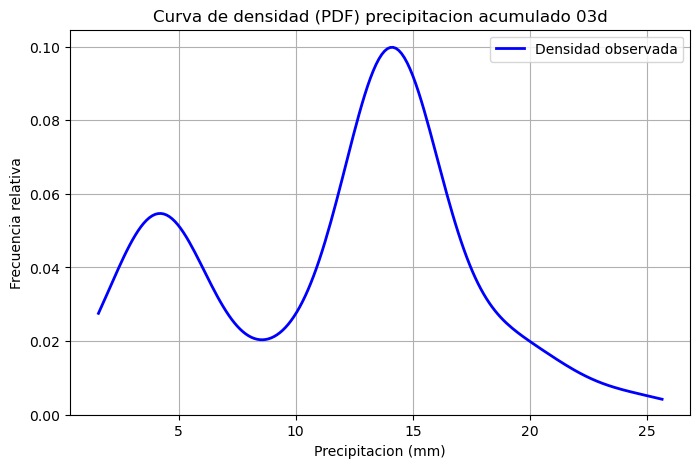

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
# Leer Excel
df = pd.read_excel("D:\\2025-1\ANALISIS_DATOS\Proyecto\Resultados_Excedencia_Corregido\\resultados_probabilidad_excedencia.xlsx")
datos = df['valor_evento_3d_mm'].dropna()



# Ajustar distribución normal
mu, sigma = norm.fit(datos)

# Rango limitado a tus datos (sin negativos)
xmin, xmax = datos.min(), datos.max()
xmin = max(0, xmin)  # evitar valores negativos
x = np.linspace(xmin, xmax, 100)

# Calcular PDF de normal ajustada
p = norm.pdf(x, mu, sigma)

# Graficar densidad observada
plt.figure(figsize=(8,5))
sns.kdeplot(datos, color="blue", linewidth=2, label="Densidad observada", clip=(xmin, xmax))

# Graficar normal ajustada
#plt.plot(x, p, 'r--', linewidth=2, label=f"Normal ajustada\nμ={mu:.2f}, σ={sigma:.2f}")

# Decoración
plt.title("Curva de densidad (PDF) precipitacion acumulado 03d")
plt.xlabel("Precipitacion (mm)")
plt.ylabel("Frecuencia relativa")

plt.legend()
plt.grid(True)
plt.show()

# Calculo valor de maxima frecuencia designados por BINS

El rango con mayor frecuencia es (14.091200000000002, 14.572400000000002) con 38 ocurrencias


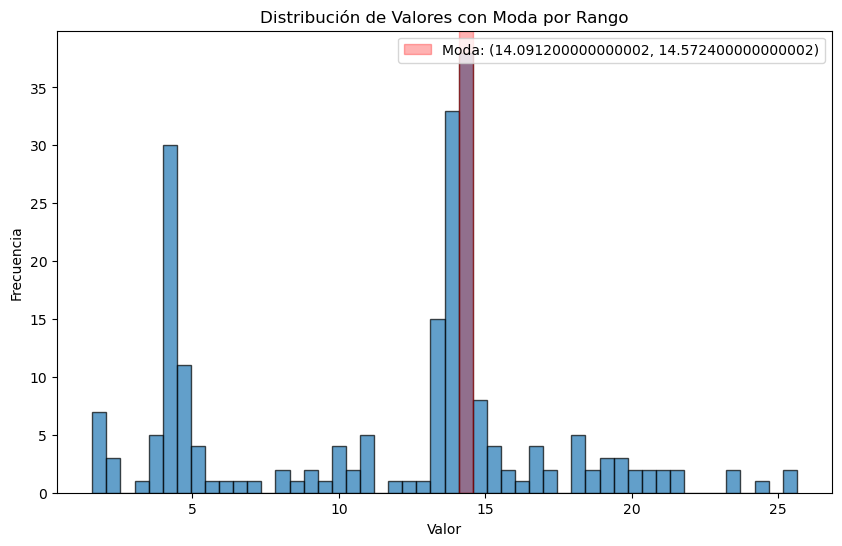

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
# Leer Excel
df = pd.read_excel("D:\\2025-1\ANALISIS_DATOS\Proyecto\Resultados_Excedencia_Corregido\\resultados_probabilidad_excedencia.xlsx")
valores = df['valor_evento_3d_mm'].dropna()

# Crear histograma con 50 bins
counts, bins = np.histogram(valores, bins=50)

# Encontrar el bin con mayor frecuencia
max_freq_idx = np.argmax(counts)
moda_rango = (bins[max_freq_idx], bins[max_freq_idx+1])
max_freq = counts[max_freq_idx]

print(f"El rango con mayor frecuencia es {moda_rango} con {max_freq} ocurrencias")

# Graficar histograma
plt.figure(figsize=(10,6))
plt.hist(valores, bins=50, edgecolor='black', alpha=0.7)
plt.axvspan(moda_rango[0], moda_rango[1], color='red', alpha=0.3, label=f"Moda: {moda_rango}")

plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.title("Distribución de Valores con Moda por Rango")
plt.legend()
plt.show()

# Calculo probabilidad de excedencia a nivel pixel para toda la zona

In [1]:
import os
import numpy as np
import rasterio

# Ruta principal
base_dir_2023 = r"D:\\2025-1\ANALISIS_DATOS\\Proyecto\\2023_procesado"
base_dir_2024 = r"D:\\2025-1\ANALISIS_DATOS\Proyecto\\2024_procesado"

# Valores umbral
X3 = 14.33   # mm acumulado 3 días
X20 = 78.455  # mm acumulado 20 días

profile = None  # Mover aquí

def cargar_rasters(base_dir):
    global profile  # Declarar como global
    lista = []
    for mes in sorted(os.listdir(base_dir)):
        carpeta = os.path.join(base_dir, mes, "Acumulados_1")
        if not os.path.isdir(carpeta):
            continue
        for archivo in sorted(os.listdir(carpeta)):
            if archivo.lower().endswith(".tif"):
                path = os.path.join(carpeta, archivo)
                with rasterio.open(path) as src:
                    if profile is None:
                        profile = src.profile
                    lista.append(src.read(1))
    return lista

# Cargar últimos 19 días de 2023 + todos los 2024
arrays_2023 = cargar_rasters(base_dir_2023)[-19:]  # últimos 19 días
arrays_2024 = cargar_rasters(base_dir_2024)

arrays = arrays_2023 + arrays_2024
stack = np.stack(arrays, axis=0)  # (tiempo, filas, columnas)

# -------------------------
# Función acumulado móvil
# -------------------------
def acumulado(stack, ventana):
    cumsum = np.cumsum(stack, axis=0)
    # acumulado[t] = cumsum[t] - cumsum[t-ventana]
    acumulados = cumsum[ventana-1:] - np.concatenate(
        [np.zeros((1, *stack.shape[1:])), cumsum[:-ventana]], axis=0
    )
    return acumulados

# Acumulados de 3 y 20 días
stack_3 = acumulado(stack, 3)
stack_20 = acumulado(stack, 20)

# Alinear dimensiones - usar el mínimo común
min_dias = min(stack_3.shape[0], stack_20.shape[0])
stack_3_aligned = stack_3[-min_dias:]
stack_20_aligned = stack_20[-min_dias:]

# Probabilidades individuales
prob_3 = (stack_3_aligned > X3).sum(axis=0) / min_dias
prob_20 = (stack_20_aligned > X20).sum(axis=0) / min_dias

# Probabilidad de intersección (ambas condiciones se cumplen)
prob_interseccion = ((stack_3_aligned > X3) & (stack_20_aligned > X20)).sum(axis=0) / min_dias

# Probabilidad de unión (una o ambas condiciones)
prob_union = prob_3 + prob_20 - prob_interseccion

# Guardar resultado adicional

# Guardar resultado adicional
with rasterio.open(r"D:\\2025-1\ANALISIS_DATOS\\Proyecto\\probabilidad_acumulado3.tif", "w", **profile) as dst:
    dst.write(prob_3.astype(np.float32), 1)

with rasterio.open(r"D:\\2025-1\ANALISIS_DATOS\\Proyecto\\probabilidad_acumulado20.tif", "w", **profile) as dst:
    dst.write(prob_20.astype(np.float32), 1)    

with rasterio.open(r"D:\\2025-1\ANALISIS_DATOS\\Proyecto\\probabilidad_union.tif", "w", **profile) as dst:
    dst.write(prob_union.astype(np.float32), 1)

with rasterio.open(r"D:\\2025-1\ANALISIS_DATOS\\Proyecto\\probabilidad_interseccion.tif", "w", **profile) as dst:
    dst.write(prob_interseccion.astype(np.float32), 1)

print("✅ Raster de probabilidad unión generado")

# Join espacial entre los municipios y la susceptibilidad por categorias

In [ ]:
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import pandas as pd
from collections import Counter

# --- ARCHIVOS ---
shp_path = r"C:\ArcGis\LOCALIZACION\MUCICIPIOS_BUENOS.shp"  # usar r"" para evitar problemas con \
raster_paths = {
    "Amenaza": {"path": r"D:\2025-1\ANALISIS_DATOS\Proyecto\RECLAS\Amenaza.tif", "nodata": [0, 15]},  # ✅ AMBOS NODATA
    "Susceptibilidad": {"path": r"D:\2025-1\ANALISIS_DATOS\Proyecto\RECLAS\Susceptibilidad.tif", "nodata": [15]}
}

# --- Cargar municipios con encoding correcto ---
print("📍 Cargando municipios...")
try:
    # ✅ SOLUCION 1: Encoding UTF-8 para caracteres especiales
    muni = gpd.read_file(shp_path, encoding='utf-8')
except:
    try:
        muni = gpd.read_file(shp_path, encoding='latin1')
    except:
        muni = gpd.read_file(shp_path)  # encoding por defecto

print(f"Municipios cargados: {len(muni)}")
print(f"Primeros municipios: {muni['MPIO_CNMBR'].head().tolist()}")

# --- Función mejorada para calcular porcentajes ---
def zonal_percentage_improved(raster_path, nodata_values, muni_gdf, field="MPIO_CNMBR"):
    """
    ✅ MEJORAS:
    - Maneja múltiples valores nodata
    - Conserva encoding de caracteres especiales
    - Formato de tabla pivotada (municipios vs categorías)
    """
    results = []
    
    with rasterio.open(raster_path) as src:
        print(f"Procesando raster: {raster_path}")
        print(f"Valores nodata definidos: {nodata_values}")
        
        municipios_procesados = 0
        municipios_con_datos = 0
        
        for idx, row in muni_gdf.iterrows():
            geom = [row.geometry]
            municipio_nombre = row[field]  # Conservar encoding original
            
            try:
                out_image, out_transform = rasterio.mask.mask(src, geom, crop=True)
            except:
                continue  # municipio fuera de cobertura
                
            data = out_image[0]
            
            # ✅ SOLUCION 3: Filtrar TODOS los valores nodata
            valid_mask = np.ones(data.shape, dtype=bool)  # Empezar con todos válidos
            
            for nodata_val in nodata_values:
                valid_mask &= (data != nodata_val)  # Excluir cada nodata
            
            valid_data = data[valid_mask]
            
            if valid_data.size == 0:
                continue  # sin datos válidos
            
            municipios_procesados += 1
            
            # Contar categorías
            counts = Counter(valid_data.flatten())
            total = sum(counts.values())
            
            if total > 0:  # Solo si hay datos
                municipios_con_datos += 1
                
                # ✅ SOLUCION 2: Crear fila con todas las categorías como columnas
                fila_resultado = {"Municipio": municipio_nombre}
                
                # Calcular porcentajes para cada categoría
                for cat, count in counts.items():
                    categoria_col = f"Cat_{int(cat)}"  # Columna por categoría
                    fila_resultado[categoria_col] = round(100 * count / total, 2)
                
                results.append(fila_resultado)
        
        print(f"   ✅ Procesados: {municipios_procesados}, Con datos: {municipios_con_datos}")
    
    return pd.DataFrame(results)

# --- Ejecutar para ambos rasters ---
print("\n🔄 Ejecutando análisis zonal...")

df_list = []
for nombre, cfg in raster_paths.items():
    print(f"\n--- Procesando {nombre} ---")
    df_temp = zonal_percentage_improved(cfg["path"], cfg["nodata"], muni)
    
    if not df_temp.empty:
        # Agregar prefijo a las columnas de categorías para diferenciar variables
        cat_columns = [col for col in df_temp.columns if col.startswith('Cat_')]
        rename_dict = {col: f"{nombre}_{col}" for col in cat_columns}
        df_temp = df_temp.rename(columns=rename_dict)
        df_list.append(df_temp)
        print(f"   ✅ {len(df_temp)} municipios procesados")
        print(f"   📊 Categorías encontradas: {cat_columns}")
    else:
        print(f"   ⚠️ No se obtuvieron datos para {nombre}")

# --- ✅ SOLUCION 2: Combinar en tabla final con formato deseado ---
if df_list:
    if len(df_list) == 1:
        df_final = df_list[0]
    else:
        # Merge por municipio para tener todo en una fila
        df_final = df_list[0]
        for df_adicional in df_list[1:]:
            df_final = pd.merge(df_final, df_adicional, on="Municipio", how="outer")
    
    # Rellenar NaN con 0 (municipios sin esa categoría)
    df_final = df_final.fillna(0)
    
    # Ordenar por municipio
    df_final = df_final.sort_values("Municipio").reset_index(drop=True)
    
    # Guardar con encoding UTF-8
    output_path = r"D:\2025-1\ANALISIS_DATOS\Proyecto\porcentajes_municipios_mejorado.csv"
    df_final.to_csv(output_path, index=False, encoding='utf-8-sig')  # utf-8-sig para Excel
    
    print(f"\n✅ Tabla final guardada: {output_path}")
    print(f"📊 Dimensiones: {df_final.shape}")
    print(f"📋 Columnas: {list(df_final.columns)}")
    print("\n🔍 Primeras 3 filas:")
    print(df_final.head(3))
    
    # Verificar caracteres especiales
    municipios_con_tildes = df_final[df_final['Municipio'].str.contains('[áéíóúñü]', case=False, na=False)]
    if not municipios_con_tildes.empty:
        print(f"\n✅ Municipios con tildes preservados correctamente:")
        print(municipios_con_tildes['Municipio'].tolist()[:5])
    
else:
    print("\n❌ No se generaron datos para ningún raster")

print("\n📋 RESUMEN DE MEJORAS APLICADAS:")
print("   1. ✅ Encoding UTF-8 para caracteres especiales (tildes, ñ, etc.)")
print("   2. ✅ Formato tabla: Municipio en filas, Categorías en columnas")
print("   3. ✅ Múltiples valores nodata para Amenaza: [0, 15]")
print("   4. ✅ Archivo guardado como 'porcentajes_municipios_mejorado.csv'")

# Join espacial y calculo de precipitacion acumulado mensual por municipio

In [24]:
import os
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import geometry_mask
from shapely.geometry import mapping

# ---------------- USER: edita estas rutas ----------------
shp_path = r"C:\ArcGis\\LOCALIZACION\\MUCICIPIOS_BUENOS.shp"
base_folder = r"D:\\2025-1\\ANALISIS_DATOS\\Proyecto\\2024_procesado"
output_csv_wide = r"D:\\2025-1\\ANALISIS_DATOS\\Proyecto\\acumulado_municipios_2024_wide.csv"
output_csv_wide_filtered = r"D:\\2025-1\\ANALISIS_DATOS\\Proyecto\\acumulado_municipios_2024_wide_filtered.csv"
output_csv_long = r"D:\\2025-1\\ANALISIS_DATOS\\Proyecto\\acumulado_municipios_2024_long.csv"
# ---------------------------------------------------------

# CONFIG: comportamiento de filtrado
COVERAGE_THRESHOLD = 0.999   # umbral de cobertura por polígono (como antes)
DROP_ALL_NAN = True         # si True elimina municipios con TODOS los meses NaN
DROP_ALL_ZERO = True        # si True elimina municipios cuyos valores (no-NaN) son TODOS cero

# --- carga shapefile ---
mun = gpd.read_file(shp_path)
if mun.crs is None:
    raise ValueError("El shapefile no tiene CRS definido. Debe tener WGS84 (EPSG:4326) según tu indicación.")
target_crs = mun.crs

# campo nombre
possible_names = ['MPIO_CNMBR']
name_field = None
for f in mun.columns:
    if f.upper() in [p.upper() for p in possible_names]:
        name_field = f
        break
if name_field is None:
    mun = mun.reset_index().rename(columns={'index':'_idx'})
    name_field = '_idx'

mun[name_field] = mun[name_field].astype(str)
municipios_list = list(mun[name_field].tolist())

months = [f"{i:02d}" for i in range(1,13)]
df_res = pd.DataFrame(index=months, columns=municipios_list, dtype=float)

def reproject_to_template(src_path, target_crs, dst_transform=None, dst_width=None, dst_height=None, dst_dtype=np.float32):
    with rasterio.open(src_path) as src:
        src_crs = src.crs if src.crs is not None else target_crs
        src_transform = src.transform

        if dst_transform is None:
            transform, width, height = calculate_default_transform(
                src_crs, target_crs, src.width, src.height, *src.bounds)
            dst_width, dst_height, dst_transform = width, height, transform
        else:
            width, height = dst_width, dst_height

        dst = np.full((height, width), np.nan, dtype=dst_dtype)

        reproject(
            source=rasterio.band(src, 1),
            destination=dst,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=target_crs,
            dst_nodata=np.nan,
            resampling=Resampling.bilinear
        )

        dst = dst.astype('float64')
        return dst, dst_transform, width, height

# --- procesamiento mensual ---
for mm in tqdm(range(1,13), desc="Meses"):
    mes = f"{mm:02d}"
    month_folder = os.path.join(base_folder, mes, "Acumulados_1")
    if not os.path.isdir(month_folder):
        print(f"[Aviso] No existe carpeta para mes {mes}: {month_folder}. Se dejarán NaN.")
        continue

    rasters = sorted(glob.glob(os.path.join(month_folder, "*.tif")) + glob.glob(os.path.join(month_folder, "*.tiff")))
    if len(rasters) == 0:
        print(f"[Aviso] No hay rásters en {month_folder}")
        continue

    monthly_sum = None
    monthly_count = None
    template_transform = None
    template_width = None
    template_height = None

    for i, rpath in enumerate(rasters):
        try:
            arr, tform, w, h = reproject_to_template(rpath, target_crs, dst_transform=template_transform, dst_width=template_width, dst_height=template_height)
        except Exception:
            if template_transform is None:
                arr, tform, w, h = reproject_to_template(rpath, target_crs, dst_transform=None, dst_width=None, dst_height=None)
            else:
                raise

        if template_transform is None:
            template_transform = tform
            template_width = w
            template_height = h
            monthly_sum = np.zeros((template_height, template_width), dtype='float64')
            monthly_count = np.zeros((template_height, template_width), dtype='int32')

        valid_mask = ~np.isnan(arr)
        monthly_sum[valid_mask] += arr[valid_mask]
        monthly_count[valid_mask] += 1

    if monthly_sum is None:
        print(f"[Aviso] No se pudo crear acumulado para mes {mes}")
        continue

    for idx, row in mun.iterrows():
        geom = row.geometry
        key = str(row[name_field])
        if geom is None or geom.is_empty:
            df_res.at[mes, key] = np.nan
            continue

        mask = geometry_mask([mapping(geom)],
                             out_shape=(template_height, template_width),
                             transform=template_transform,
                             invert=True)

        pixels_inside = np.count_nonzero(mask)
        if pixels_inside == 0:
            df_res.at[mes, key] = np.nan
            continue

        valid_pixels_inside = np.count_nonzero((monthly_count > 0) & mask)
        coverage = valid_pixels_inside / pixels_inside

        if coverage + 1e-12 < COVERAGE_THRESHOLD:
            df_res.at[mes, key] = np.nan
            continue

        valid = (monthly_count > 0) & mask
        vals = monthly_sum[valid]
        mean_mm = float(np.nanmean(vals)) if vals.size > 0 else np.nan
        df_res.at[mes, key] = mean_mm

# renombra filas
df_res.index = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']

# guarda tabla wide completa (con todos los municipios originales)
os.makedirs(os.path.dirname(output_csv_wide), exist_ok=True)
df_res.to_csv(output_csv_wide, index=True)
print("Tabla wide (completa) guardada en:", output_csv_wide)

# genera tabla long
df_long = df_res.reset_index().melt(id_vars='index', var_name='Municipio', value_name='Precip_mm')
df_long = df_long.rename(columns={'index':'Mes'})
os.makedirs(os.path.dirname(output_csv_long), exist_ok=True)
df_long.to_csv(output_csv_long, index=False)
print("Tabla long guardada en:", output_csv_long)

# --- FILTRADO: detecta municipios que se eliminarán ---
to_drop_nan = []
to_drop_zero = []
for col in df_res.columns:
    col_series = df_res[col]
    # cuantos meses no-NaN
    n_valid = col_series.notna().sum()
    if n_valid == 0:
        to_drop_nan.append(col)
        continue
    # si quedan valores no-NaN, revisa si TODOS los valores no-NaN son cero
    non_na = col_series.dropna()
    if (non_na == 0).all():
        to_drop_zero.append(col)

dropped_reasons = {}
if DROP_ALL_NAN:
    for c in to_drop_nan:
        dropped_reasons[c] = 'ALL_NAN'
if DROP_ALL_ZERO:
    for c in to_drop_zero:
        # evita sobreescribir la razón si ya estaba en ALL_NAN
        if c in dropped_reasons:
            continue
        dropped_reasons[c] = 'ALL_ZERO'

# crea df filtrado aplicando ambos criterios según configuración
df_filtered = df_res.copy()
cols_to_drop = []
if DROP_ALL_NAN:
    cols_to_drop += to_drop_nan
if DROP_ALL_ZERO:
    # evita añadir dos veces
    cols_to_drop += [c for c in to_drop_zero if c not in cols_to_drop]

if len(cols_to_drop) > 0:
    df_filtered = df_filtered.drop(columns=cols_to_drop)

# guarda filtrado
os.makedirs(os.path.dirname(output_csv_wide_filtered), exist_ok=True)
df_filtered.to_csv(output_csv_wide_filtered, index=True)
print("Tabla wide filtrada guardada en:", output_csv_wide_filtered)

# informe resumido
print("Resumen de filtrado:")
print(f"  - Municipios detectados inicialmente: {len(df_res.columns)}")
print(f"  - Municipios eliminados por ALL_NAN: {len(to_drop_nan)}")
print(f"  - Municipios eliminados por ALL_ZERO: {len([c for c in to_drop_zero if c not in to_drop_nan])}")
if len(dropped_reasons) > 0:
    # muestra ejemplos (hasta 50)
    sample = list(dropped_reasons.items())[:50]
    for k,v in sample:
        print(f"    -> {k}: {v}")
else:
    print("  - No se eliminaron municipios según los criterios configurados.")

print("Proceso completado.")


Meses: 100%|██████████| 12/12 [08:44<00:00, 43.68s/it]


Tabla wide (completa) guardada en: D:\\2025-1\\ANALISIS_DATOS\\Proyecto\\acumulado_municipios_2024_wide.csv
Tabla long guardada en: D:\\2025-1\\ANALISIS_DATOS\\Proyecto\\acumulado_municipios_2024_long.csv


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

# Normalizacion de nombres de los municipios en las tablas de susceptibilidad, amenaza y acumulado de precipitacion

In [3]:
import pandas as pd
import numpy as np
import unicodedata
import os

# --------------- CONFIG: rutas (edita) ----------------
csv1_path = r"D:\\2025-1\ANALISIS_DATOS\\Proyecto\\porcentajes_municipios_mejorado.csv"   # ejemplo: primera imagen (columna "Municipio")
csv2_path = r"D:\\2025-1\ANALISIS_DATOS\\Proyecto\Acumulado_Municipios.csv"  # ejemplo: segunda imagen (meses x columnas municipios)
out1_path = r"D:\\2025-1\ANALISIS_DATOS\\Proyecto\\porcentajes_municipios_mejorado_2.csv"
out2_path = r"D:\\2025-1\ANALISIS_DATOS\\Proyecto\Acumulado_Municipios_2.csv"
# ------------------------------------------------------

# lee ambos CSV como strings
df1 = pd.read_csv(csv1_path, dtype=str)
df2 = pd.read_csv(csv2_path, dtype=str)

# función simple: limpiar solo espacios al inicio/final (NO normaliza acentos ni cambia mayúsculas)
def strip_only(x):
    if pd.isna(x):
        return ""
    return str(x).strip()

# --- IDENTIFICAR columna "Municipio" en df1 ---
# Buscamos nombres comunes exactos (sin normalizar). Si no se encuentra, usamos la primera columna.
possible_names = ['Municipio','municipio','MUNICIPIO','MPIO_CNMBR','MPIO_CNMBR ']  # puedes añadir exactamente el nombre que tengas en el header
col_mun_df1 = None
for c in df1.columns:
    if c in possible_names:
        col_mun_df1 = c
        break
if col_mun_df1 is None:
    col_mun_df1 = df1.columns[0]
    print(f"[Aviso] No se encontró explícitamente 'Municipio' en CSV1. Usando la primera columna: '{col_mun_df1}'")

# --- DETECTAR SI df2 TIENE MESES EN LA PRIMERA COLUMNA (entonces los municipios están como columnas) ---
# Aquí hacemos una comprobación sencilla: si varios valores de la primera columna coinciden con
# nombres de mes (Enero..Diciembre) en cualquiera de las tres capitalizaciones más comunes,
# asumimos que es columna de meses. Esta detección no altera los textos de los municipios.
month_variants = {"Enero","Febrero","Marzo","Abril","Mayo","Junio","Julio","Agosto","Septiembre","Octubre","Noviembre","Diciembre",
                  "enero","febrero","marzo","abril","mayo","junio","julio","agosto","septiembre","octubre","noviembre","diciembre",
                  "ENERO","FEBRERO","MARZO","ABRIL","MAYO","JUNIO","JULIO","AGOSTO","SEPTIEMBRE","OCTUBRE","NOVIEMBRE","DICIEMBRE"}

first_col_df2 = df2.columns[0]
vals = df2[first_col_df2].dropna().astype(str).map(strip_only).tolist()
matches = sum(1 for v in vals if v in month_variants)
df2_firstcol_is_months = (len(vals) > 0 and matches >= max(3, int(0.6 * len(vals))))  # >=60% o al menos 3 coincidencias

# --- OBTENER LISTAS DE MUNICIPIOS (SIN NORMALIZAR, solo strip) ---
# Para df1 (fila-based)
mun_df1_orig = df1[col_mun_df1].astype(str).map(strip_only).tolist()
mun_df1_set = set([m for m in mun_df1_orig if m != ""])

# Para df2:
if df2_firstcol_is_months:
    # municipios = nombres de columnas excepto la primera
    mun_df2_cols = [c for c in df2.columns if c != first_col_df2]
    mun_df2_orig = [strip_only(c) for c in mun_df2_cols]
    mun_df2_set = set([m for m in mun_df2_orig if m != ""])
else:
    # asumimos df2 también tiene columna de municipios (fila-based). Tomamos la primera coincidencia de nombre 'Municipio' si existe
    col_mun_df2 = None
    for c in df2.columns:
        if c in possible_names:
            col_mun_df2 = c
            break
    if col_mun_df2 is None:
        col_mun_df2 = df2.columns[0]
        print(f"[Aviso] CSV2 no parecía tener meses en la 1a columna ni un header 'Municipio' conocido. Usando la primera columna: '{col_mun_df2}'")
    mun_df2_orig = df2[col_mun_df2].astype(str).map(strip_only).tolist()
    mun_df2_set = set([m for m in mun_df2_orig if m != ""])

# --- INTERSECCIÓN EXACTA (sin normalizar acentos ni cambiar mayúsculas) ---
common = sorted(list(mun_df1_set.intersection(mun_df2_set)))

print(f"Municipios en CSV1 (únicos, sin normalizar): {len(mun_df1_set)}")
print(f"Municipios en CSV2 (únicos, sin normalizar): {len(mun_df2_set)}")
print(f"Municipios en común (match EXACTO después de strip): {len(common)}")

# --- FILTRAR DATAFRAMES conservando solo los municipios que están en la intersección ---
# df1: fila-based -> filtramos por la columna de municipio detectada
mask1 = df1[col_mun_df1].astype(str).map(strip_only).isin(common)
df1_filtered = df1[mask1].copy()

# df2:
if df2_firstcol_is_months:
    cols_to_keep = [first_col_df2] + [c for c in df2.columns if strip_only(c) in common and c != first_col_df2]
    # mantener orden original
    cols_to_keep = [c for c in df2.columns if c in cols_to_keep]
    df2_filtered = df2[cols_to_keep].copy()
else:
    mask2 = df2[col_mun_df2].astype(str).map(strip_only).isin(common)
    df2_filtered = df2[mask2].copy()

# guarda resultados
os.makedirs(os.path.dirname(out1_path), exist_ok=True)
df1_filtered.to_csv(out1_path, index=False)
df2_filtered.to_csv(out2_path, index=False)

# informe
removed_from_df1 = sorted(set(mun_df1_set) - set([strip_only(x) for x in df1_filtered[col_mun_df1].astype(str).tolist()]))
if df2_firstcol_is_months:
    removed_from_df2 = sorted([strip_only(c) for c in df2.columns if c != first_col_df2 and strip_only(c) not in [strip_only(x) for x in df2_filtered.columns if x!=first_col_df2]])
else:
    removed_from_df2 = sorted(set(mun_df2_set) - set([strip_only(x) for x in df2_filtered[col_mun_df2].astype(str).tolist()]))

print("----- Resumen -----")
print(f"CSV1 original filas: {len(df1)} -> filas tras filtrar: {len(df1_filtered)}")
print(f"CSV2 original shape: {df2.shape} -> tras filtrar: {df2_filtered.shape}")
print(f"Ejemplo municipios comunes (hasta 20): {common[:20]}")
print(f"Municipios eliminados de CSV1 (ejemplo hasta 20): {removed_from_df1[:20]}")
print(f"Municipios eliminados de CSV2 (ejemplo hasta 20): {removed_from_df2[:20]}")
print("Archivos filtrados guardados en:")
print(" -", out1_path)
print(" -", out2_path)

Municipios en CSV1 (únicos, sin normalizar): 147
Municipios en CSV2 (únicos, sin normalizar): 126
Municipios en común (match EXACTO después de strip): 123
----- Resumen -----
CSV1 original filas: 147 -> filas tras filtrar: 123
CSV2 original shape: (12, 127) -> tras filtrar: (12, 124)
Ejemplo municipios comunes (hasta 20): ['ABEJORRAL', 'ABRIAQUÍ', 'AGUADAS', 'ALEJANDRÍA', 'AMAGÁ', 'AMALFI', 'ANDES', 'ANGELÓPOLIS', 'ANGOSTURA', 'ANORÍ', 'ANSERMA', 'ANZÁ', 'APÍA', 'ARANZAZU', 'BAGADÓ', 'BELLO', 'BELMIRA', 'BELÉN DE UMBRÍA', 'BETANIA', 'BOLÍVAR']
Municipios eliminados de CSV1 (ejemplo hasta 20): ['ARGELIA', 'ARMENIA', 'BARBOSA', 'BETULIA', 'BRICEÑO', 'CALDAS', 'CONCEPCIÓN', 'CONCORDIA', 'GRANADA', 'GUADALUPE', 'JERICÓ', 'LA UNIÓN', 'NARIÑO', 'RIONEGRO', 'RIOSUCIO', 'SABANALARGA', 'SALAMINA', 'SAN CARLOS', 'SAN FRANCISCO', 'SAN LUIS']
Municipios eliminados de CSV2 (ejemplo hasta 20): ['ATRATO', 'BOLÍVAR.1', 'BOLÍVAR.2']
Archivos filtrados guardados en:
 - D:\\2025-1\ANALISIS_DATOS\\Proyect

# Conversion tabla para el uso y grafico en power BI

In [8]:
import pandas as pd

# Cargar tu CSV (ajusta la ruta al archivo)
df = pd.read_csv("D:\\2025-1\ANALISIS_DATOS\Proyecto\Acumulado_Municipios_2.csv")

# La primera columna son los meses
df = df.rename(columns={df.columns[0]: "Mes"})

# Hacemos melt: pasamos de columnas de municipios -> filas
df_long = df.melt(id_vars=["Mes"], 
                  var_name="Municipio", 
                  value_name="Acumulado")

# Crear número de mes (para ordenar en Power BI)
meses = ["Enero","Febrero","Marzo","Abril","Mayo","Junio",
         "Julio","Agosto","Septiembre","Octubre","Noviembre","Diciembre"]

df_long["Mes_numero"] = df_long["Mes"].apply(lambda x: meses.index(x) + 1)

# Guardar resultado
df_long.to_csv("D:\\2025-1\ANALISIS_DATOS\Proyecto\Acumulado_Municipios_3.csv", index=False)